In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as plt

In [2]:
# Load in mta 2018 pickle file
mta_data = pd.read_pickle('mta_2018')
mta_data

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2018,00:00:00,REGULAR,6598847,2235829
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2018,04:00:00,REGULAR,6598864,2235830
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2018,08:00:00,REGULAR,6598880,2235863
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2018,12:00:00,REGULAR,6598961,2235955
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2018,16:00:00,REGULAR,6599175,2236015
...,...,...,...,...,...,...,...,...,...,...,...
196681,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/22/2018,05:00:00,REGULAR,2943952,387457
196682,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/22/2018,09:00:00,REGULAR,2944236,387461
196683,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/22/2018,13:00:00,REGULAR,2944660,387473
196684,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/22/2018,17:00:00,REGULAR,2945138,387484


In [3]:
# Check columns names for errors
mta_data.columns.values

array(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE',
       'TIME', 'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype=object)

In [4]:
#  Fix EXITS column name
mta_data.rename(columns={'EXITS                                                               ':'EXITS'}, inplace=True)

In [5]:
#  Check for empty values
mta_data.isna().sum()

C/A         0
UNIT        0
SCP         0
STATION     0
LINENAME    0
DIVISION    0
DATE        0
TIME        0
DESC        0
ENTRIES     0
EXITS       0
dtype: int64

In [6]:
# Create DateTime column
mta_data['DATETIME'] = pd.to_datetime(mta_data.DATE + ' ' + mta_data.TIME)
mta_data['DATE']= pd.to_datetime(mta_data['DATE'])

In [7]:
# Create Day of Week from newly create DateTime column
mta_data['WEEKDAY'] = mta_data['DATETIME'].dt.day_name()

In [8]:
# Create ID for each turnstile
mta_data['UNIQUEID'] = mta_data['STATION'] + '_' + mta_data['UNIT'] + '_' + mta_data['C/A']

In [9]:
# Create Time of Day
mta_data['TIMEOFDAY'] = mta_data['DATETIME'].dt.hour

# def convertTimeOfDay(column):
#     if column > 19:
#         return 'NIGHTTIME'
#     elif (column > 16) & :
#         return 'Short'
#     return ''

# df['TIMEOFDAY'] = df['TIMEOFDAY'].apply(applyFunc)
# df

In [10]:
# Daily Counts by Turnstile
df = mta_data.groupby(['UNIQUEID', 'DATE'], as_index=False)
df = df.last().drop_duplicates()
df['ENTRYDIFF'] = df['ENTRIES'].diff()
df['EXITDIFF'] = df['EXITS'].diff()

In [11]:
# Drop Rows without changes
df.dropna(subset=['ENTRYDIFF', 'EXITDIFF'], inplace=True)

# Drop First Day in Groups
df = df[df.DATETIME >= mta_data.DATE.min() + pd.DateOffset(days=1)]

In [12]:
df['ENTRYDIFF'] = df['ENTRYDIFF'].astype(int)
df['EXITDIFF'] = df['EXITDIFF'].astype(int)
df['TRAFFIC'] = df['ENTRYDIFF'] + df['EXITDIFF']

In [13]:
# Drop Rows with extreme swings in traffic values
df = df[df.TRAFFIC <= 50000]
df = df[df.TRAFFIC > 0]

In [14]:
# Shift Station Column
df = df[['STATION', 'UNIT', 'UNIQUEID', 'DATE', 'C/A', 'SCP', 'LINENAME', 'DIVISION', 'TIME', 'DESC', 'ENTRIES', 'EXITS', 'DATETIME', 'WEEKDAY', 'TIMEOFDAY', 'ENTRYDIFF', 'EXITDIFF', 'TRAFFIC']]
df


,STATION,UNIT,UNIQUEID,DATE,C/A,SCP,LINENAME,DIVISION,TIME,DESC,ENTRIES,EXITS,DATETIME,WEEKDAY,TIMEOFDAY,ENTRYDIFF,EXITDIFF,TRAFFIC
1,1 AV,R248,1 AV_R248_H007,2018-04-29,H007,00-03-02,L,BMT,20:00:00,REGULAR,5968446,500854,2018-04-29 20:00:00,Sunday,20,907,151,1058
2,1 AV,R248,1 AV_R248_H007,2018-04-30,H007,00-03-02,L,BMT,20:00:00,REGULAR,5969833,500993,2018-04-30 20:00:00,Monday,20,1387,139,1526
3,1 AV,R248,1 AV_R248_H007,2018-05-01,H007,00-03-02,L,BMT,20:00:00,REGULAR,5971110,501082,2018-05-01 20:00:00,Tuesday,20,1277,89,1366
4,1 AV,R248,1 AV_R248_H007,2018-05-02,H007,00-03-02,L,BMT,20:00:00,REGULAR,5972383,501218,2018-05-02 20:00:00,Wednesday,20,1273,136,1409
5,1 AV,R248,1 AV_R248_H007,2018-05-03,H007,00-03-02,L,BMT,20:00:00,REGULAR,5973738,501331,2018-05-03 20:00:00,Thursday,20,1355,113,1468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40914,YORK ST,R301,YORK ST_R301_N530,2018-06-22,N530,00-00-02,F,IND,21:00:00,REGULAR,10939367,1540640,2018-06-22 21:00:00,Friday,21,3110,263,3373
40919,ZEREGA AV,R326,ZEREGA AV_R326_R419,2018-05-02,R419,00-05-01,6,IRT,21:00:00,REGULAR,39,102,2018-05-02 21:00:00,Wednesday,21,0,1,1
40939,ZEREGA AV,R326,ZEREGA AV_R326_R419,2018-05-22,R419,00-05-01,6,IRT,21:00:00,REGULAR,39,103,2018-05-22 21:00:00,Tuesday,21,0,1,1
40964,ZEREGA AV,R326,ZEREGA AV_R326_R419,2018-06-16,R419,00-05-01,6,IRT,21:00:00,REGULAR,39,106,2018-06-16 21:00:00,Saturday,21,0,3,3


In [20]:
# Export df to csv
df.to_csv('mta_2018_processed.csv')

In [16]:
# Group traffic values by station and date
daily_traffic = df.groupby(['STATION','DATE'], as_index=False).TRAFFIC.sum().sort_values('TRAFFIC', ascending=False)
# daily_traffic = daily_traffic.head(1000)
daily_traffic

,STATION,DATE,TRAFFIC
2427,23 ST,2018-05-16,43006
2428,23 ST,2018-05-17,41641
2426,23 ST,2018-05-15,41595
2413,23 ST,2018-05-02,41483
2414,23 ST,2018-05-03,40901
...,...,...,...
7169,BEACH 90 ST,2018-06-19,1
7170,BEACH 90 ST,2018-06-20,1
7171,BEACH 98 ST,2018-05-01,1
7172,BEACH 98 ST,2018-06-12,1


In [17]:
stations_wide = daily_traffic.pivot("DATE", "STATION", "TRAFFIC")

top_count = 10

# Remove stations that never ranked in the top X
def topStations(output, input, x_count):
    top_stations = set()

    for index, row in input.iterrows():
        top_stations |= set(row[row > 0].sort_values(ascending=False).head(x_count).index)

    return output[list(top_stations)]

stations_wide = topStations(stations_wide, stations_wide, top_count)
# stations_wide = topStations(df, stations_wide, top_count)

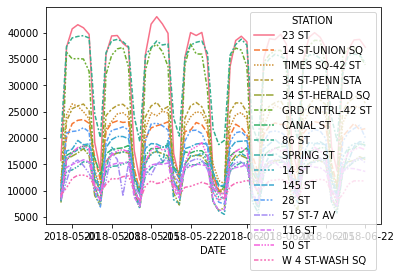

In [18]:
lp = sns.lineplot(data=stations_wide)
sns.set(rc={'figure.figsize':(35,15)})

In [19]:
daily_traffic.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,TRAFFIC
count,18230.00000
mean,3733.94558
std,4661.88843
min,1.00000
25%,1168.00000
50%,2295.50000
75%,4426.75000
max,43006.00000
